# Tuần 2: Dự đoán chuỗi thời gian

Chào mừng! Trong bài tập trước, bạn đã được tiếp xúc một chút với cách làm việc với dữ liệu chuỗi thời gian, nhưng bạn chưa sử dụng các kỹ thuật máy học cho dự báo của mình. Tuần này, bạn sẽ sử dụng mạng lưới thần kinh sâu để tạo dự báo nhằm xem kỹ thuật này so sánh như thế nào với kỹ thuật bạn đã thử. Một lần nữa tất cả dữ liệu sẽ được tạo ra.

Bắt đầu nào!

_**LƯU Ý:** Để tránh lỗi từ hệ thống tự động chấm, bạn không được phép chỉnh sửa hoặc xóa một số ô trong sổ tay này. Vui lòng chỉ đặt giải pháp của bạn ở giữa nhận xét mã `### BẮT ĐẦU MÃ TẠI ĐÂY` và `### KẾT THÚC MÃ KẾT THÚC TẠI ĐÂY`, đồng thời không thêm bất kỳ ô mới nào. **Khi bạn đã vượt qua bài tập này** và muốn thử nghiệm với bất kỳ ô nào bị khóa, bạn có thể làm theo hướng dẫn ở cuối sổ ghi chép này._

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass

## Tạo dữ liệu


Ô tiếp theo bao gồm một loạt các hàm trợ giúp để tạo và vẽ biểu đồ chuỗi thời gian:

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """An arbitrary pattern"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi), 
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

Bạn sẽ tạo dữ liệu chuỗi thời gian rất giống với dữ liệu của tuần trước nhưng có một số khác biệt.

**Lưu ý rằng lần này tất cả việc tạo được thực hiện trong một hàm và các biến toàn cục được lưu trong một lớp dữ liệu. Điều này được thực hiện để tránh sử dụng phạm vi toàn cầu như đã được thực hiện trong tuần trước.**

Nếu trước đây bạn chưa từng sử dụng các lớp dữ liệu thì chúng chỉ là các lớp Python cung cấp cú pháp thuận tiện để lưu trữ dữ liệu. Bạn có thể đọc thêm về chúng trong [docs](https://docs.python.org/3/library/dataclasses.html).

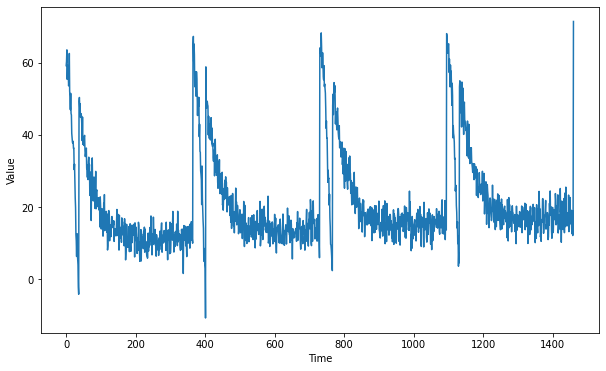

In [3]:
def generate_time_series():
    # The time dimension or the x-coordinate of the time series
    time = np.arange(4 * 365 + 1, dtype="float32")

    # Initial series is just a straight line with a y-intercept
    y_intercept = 10
    slope = 0.005
    series = trend(time, slope) + y_intercept

    # Adding seasonality
    amplitude = 50
    series += seasonality(time, period=365, amplitude=amplitude)

    # Adding some noise
    noise_level = 3
    series += noise(time, noise_level, seed=51)
    
    return time, series


# Save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    TIME, SERIES = generate_time_series()
    SPLIT_TIME = 1100
    WINDOW_SIZE = 20
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000
    

# Plot the generated series
plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

## Tách dữ liệu

Vì bạn đã mã hóa hàm `train_val_split` trong bài tập tuần trước nên lần này nó được cung cấp cho bạn:

In [4]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

## Xử lý dữ liệu

Như bạn đã thấy trong các bài giảng, bạn có thể cung cấp dữ liệu cho việc đào tạo bằng cách tạo một tập dữ liệu với các bước xử lý thích hợp như `windowing`, `flattening`, `batching` và `shuffling`. Để làm như vậy, hãy hoàn thành hàm `windowed_dataset` bên dưới.

Lưu ý rằng hàm này nhận được một `series`, `window_size`, `batch_size` và `shuffle_buffer` và ba giá trị cuối cùng trong số này mặc định là các giá trị "toàn cục" được xác định trước đó.

Hãy nhớ xem [docs](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) về `Bộ dữ liệu TF` nếu bạn cần bất kỳ trợ giúp nào.

In [5]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    
    ### START CODE HERE
    
    # Create dataset from the series
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Slice the dataset into the appropriate windows
    dataset = dataset.window(size=window_size+1, shift=1, drop_remainder=True)
    
    # Flatten the dataset
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    
    # Shuffle it
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Split it into the features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    
    # Batch it
    dataset = dataset.batch(batch_size).prefetch(1)
    
    ### END CODE HERE
    
    return dataset

Để kiểm tra hàm, bạn sẽ sử dụng `window_size` bằng 1, nghĩa là bạn sẽ sử dụng từng giá trị để dự đoán giá trị tiếp theo. Điều này dành cho 5 phần tử vì `batch_size` gồm 5 phần tử được sử dụng và không xáo trộn vì `shuffle_buffer` được đặt thành 1.

Vì điều này, lô tính năng phải giống với 5 phần tử đầu tiên của `series_train` và lô nhãn phải bằng các phần tử từ 2 đến 6 của `series_train`.

In [6]:
# Test your function with windows size of 1 and no shuffling
test_dataset = windowed_dataset(series_train, window_size=1, batch_size=5, shuffle_buffer=1)

# Get the first batch of the test dataset
batch_of_features, batch_of_labels = next((iter(test_dataset)))

print(f"batch_of_features has type: {type(batch_of_features)}\n")
print(f"batch_of_labels has type: {type(batch_of_labels)}\n")
print(f"batch_of_features has shape: {batch_of_features.shape}\n")
print(f"batch_of_labels has shape: {batch_of_labels.shape}\n")
print(f"batch_of_features is equal to first five elements in the series: {np.allclose(batch_of_features.numpy().flatten(), series_train[:5])}\n")
print(f"batch_of_labels is equal to first five labels: {np.allclose(batch_of_labels.numpy(), series_train[1:6])}")

batch_of_features has type: <class 'tensorflow.python.framework.ops.EagerTensor'>

batch_of_labels has type: <class 'tensorflow.python.framework.ops.EagerTensor'>

batch_of_features has shape: (5, 1)

batch_of_labels has shape: (5,)

batch_of_features is equal to first five elements in the series: True

batch_of_labels is equal to first five labels: True


**Đầu ra dự kiến:**

```
batch_of_features has type: <class 'tensorflow.python.framework.ops.EagerTensor'>

batch_of_labels has type: <class 'tensorflow.python.framework.ops.EagerTensor'>

batch_of_features has shape: (5, 1)

batch_of_labels has shape: (5,)

batch_of_features is equal to first five elements in the series: True

batch_of_labels is equal to first five labels: True
```

## Xác định kiến ​​trúc mô hình

Bây giờ bạn đã có một hàm sẽ xử lý dữ liệu trước khi dữ liệu được đưa vào mạng thần kinh của bạn để huấn luyện, đã đến lúc xác định kiến ​​trúc lớp của bạn.

Hoàn thành hàm `create_model` bên dưới. Lưu ý rằng hàm này nhận được `window_size` vì đây sẽ là một tham số quan trọng cho lớp đầu tiên trong mạng của bạn.

Gợi ý:
- Bạn sẽ chỉ cần các lớp `Dense`.
- Không bao gồm các lớp `Lambda`. Những điều này không bắt buộc và không tương thích với định dạng `HDF5` sẽ được sử dụng để lưu mô hình của bạn để phân loại.
- Quá trình đào tạo phải thực sự nhanh chóng, vì vậy nếu bạn nhận thấy rằng mỗi kỷ nguyên mất hơn vài giây, hãy cân nhắc thử một kiến ​​trúc khác.

In [7]:
def create_model(window_size=G.WINDOW_SIZE):

    ### START CODE HERE

    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1)
    ]) 

    model.compile(loss='mse',
                  optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
    
    ### END CODE HERE

    return model

In [8]:
# Apply the processing to the whole training series
dataset = windowed_dataset(series_train)

# Save an instance of the model
model = create_model()

# Train it
model.fit(dataset, epochs=100)

Epoch 1/100
34/34 [==============================] - 1s 9ms/step - loss: 551.9153
Epoch 2/100
34/34 [==============================] - 0s 815us/step - loss: 80.7894
Epoch 3/100
34/34 [==============================] - 0s 931us/step - loss: 72.1685
Epoch 4/100
34/34 [==============================] - 0s 999us/step - loss: 67.8810
Epoch 5/100
34/34 [==============================] - 0s 881us/step - loss: 64.6437
Epoch 6/100
34/34 [==============================] - 0s 971us/step - loss: 61.8222
Epoch 7/100
34/34 [==============================] - 0s 942us/step - loss: 59.1650
Epoch 8/100
34/34 [==============================] - 0s 2ms/step - loss: 56.8216
Epoch 9/100
34/34 [==============================] - 0s 853us/step - loss: 54.8899
Epoch 10/100
34/34 [==============================] - 0s 976us/step - loss: 52.9685
Epoch 11/100
34/34 [==============================] - 0s 841us/step - loss: 51.3044
Epoch 12/100
34/34 [==============================] - 0s 959us/step - loss: 49.1584
Epoc

##Đánh giá dự báo

Bây giờ là lúc đánh giá hiệu quả của dự báo. Để làm điều này, bạn có thể sử dụng hàm `compute_metrics` mà bạn đã mã hóa trong bài tập trước:

In [9]:
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

Tại thời điểm này, chỉ có mô hình thực hiện dự báo đã sẵn sàng nhưng bạn vẫn cần tính toán dự báo thực tế.

Để làm điều này, hãy chạy ô bên dưới sử dụng hàm `generate_forecast` để tính toán dự báo. Hàm này tạo giá trị tiếp theo dựa trên tập hợp các điểm `window_size` trước đó cho mọi điểm trong tập hợp xác thực.

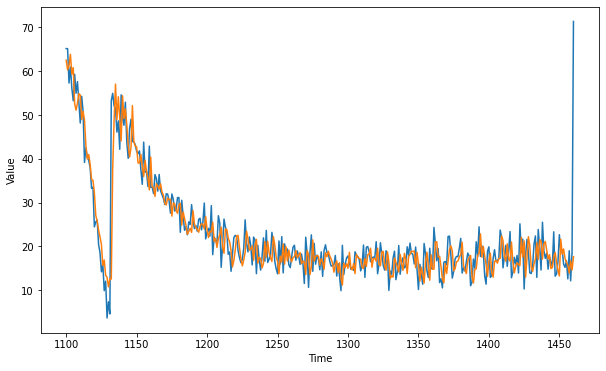

In [10]:
def generate_forecast(series=G.SERIES, split_time=G.SPLIT_TIME, window_size=G.WINDOW_SIZE):
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

    forecast = forecast[split_time-window_size:]
    results = np.array(forecast)[:, 0, 0]
    return results


# Save the forecast
dnn_forecast = generate_forecast()

# Plot it
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, dnn_forecast)

**Đầu ra dự kiến:**

Một loạt tương tự như thế này:

<div>
<img src="images/forecast.png" width="500"/>
</div>

In [11]:
mse, mae = compute_metrics(series_valid, dnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 29.60, mae: 3.47 for forecast


**Để vượt qua nhiệm vụ này, dự báo của bạn phải đạt được MSE từ 30 trở xuống.**

- Nếu dự báo của bạn không đạt được ngưỡng này, hãy thử đào tạo lại mô hình của bạn bằng kiến ​​trúc khác hoặc điều chỉnh các tham số của trình tối ưu hóa.


- Nếu dự báo của bạn đã đạt được ngưỡng này, hãy chạy ô sau để lưu mô hình của bạn vào tệp tệp HDF5. Tệp này sẽ được sử dụng để chấm điểm và sau khi làm như vậy, hãy gửi bài tập của bạn để chấm điểm.


- Đảm bảo bạn không sử dụng các lớp `Lambda` trong mô hình của mình vì những lớp này không tương thích với định dạng `HDF5` sẽ được sử dụng để lưu mô hình của bạn để phân loại.


- Môi trường này bao gồm tệp `my_model.h5` giả, đây chỉ là một mô hình giả được đào tạo cho một kỷ nguyên. **Để thay thế tệp này bằng mô hình thực tế của bạn, bạn cần chạy ô tiếp theo trước khi gửi để chấm điểm.**

In [12]:
# Save your model in HDF5 format
model.save('my_model.h5')

**Chúc mừng bạn đã hoàn thành bài tập tuần này!**

Bạn đã triển khai thành công mạng nơ-ron có khả năng dự báo chuỗi thời gian đồng thời học cách tận dụng lớp Tập dữ liệu của Tensorflow để xử lý dữ liệu chuỗi thời gian!

**Cố lên!**

<chi tiết>
<summary><font size="2" color="darkgreen"><b>Vui lòng nhấp vào đây nếu bạn muốn thử nghiệm bất kỳ mã nào không được phân loại.</b></font></summary>
<p><i><b>Lưu ý quan trọng: Vui lòng chỉ thực hiện việc này khi bạn đã vượt qua bài tập để tránh sự cố với hệ thống tự động chấm điểm.</b></i>
<ol>
<li> Trên menu của sổ ghi chép, hãy nhấp vào “Xem” > “Thanh công cụ di động” > “Chỉnh sửa siêu dữ liệu”</li>
<li> Nhấn nút “Chỉnh sửa siêu dữ liệu” bên cạnh ô mã mà bạn muốn khóa/mở khóa</li>
<li> Đặt giá trị thuộc tính cho “có thể chỉnh sửa” thành:
<ul>
<li> “đúng” nếu bạn muốn mở khóa </li>
<li> “false” nếu bạn muốn khóa nó </li>
</ul>
</li>
<li> Trên menu của sổ ghi chép, hãy nhấp vào “Xem” > “Thanh công cụ di động” > “Không có” </li>
</ol>
<p> Dưới đây là bản demo ngắn về cách thực hiện các bước trên:
<br>
<img src="https://drive.google.com/uc?export=view&id=14Xy_Mb17CZVgzVAgq7NCjMVBvSae3xO1"align="center">
</ chi tiết>